In [2]:
# Standard Libraries
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
# For visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data-Prep
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

# Model Buidling and metrics
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score

In [3]:
import chardet

with open('/content/customer_booking.csv', 'rb') as rawdata:
  result = chardet.detect(rawdata.read(100000))

print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [60]:
data = pd.read_csv("/content/customer_booking.csv", encoding="ISO-8859-1")

In [61]:
data.booking_complete.value_counts()

0    42522
1     7478
Name: booking_complete, dtype: int64

Exploratory Data Analysis

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

No Null values

In [62]:
# Separating categorical and numerical columns
data_categorical = data.select_dtypes(include="object")
data_numerical = data.select_dtypes(exclude="object")

In [63]:
for col in data_categorical:
    print(data_categorical[col].value_counts())
    print("\n")

Internet    44382
Mobile       5618
Name: sales_channel, dtype: int64


RoundTrip     49497
OneWay          387
CircleTrip      116
Name: trip_type, dtype: int64


Mon    8102
Wed    7674
Tue    7673
Thu    7424
Fri    6761
Sun    6554
Sat    5812
Name: flight_day, dtype: int64


AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
          ... 
LBUTPE       1
CXRMEL       1
DELKBR       1
KOSSYD       1
MRUXIY       1
Name: route, Length: 799, dtype: int64


Australia               17872
Malaysia                 7174
South Korea              4559
Japan                    3885
China                    3387
                        ...  
Panama                      1
Tonga                       1
Tanzania                    1
Bulgaria                    1
Svalbard & Jan Mayen        1
Name: booking_origin, Length: 104, dtype: int64




Outlier Detection

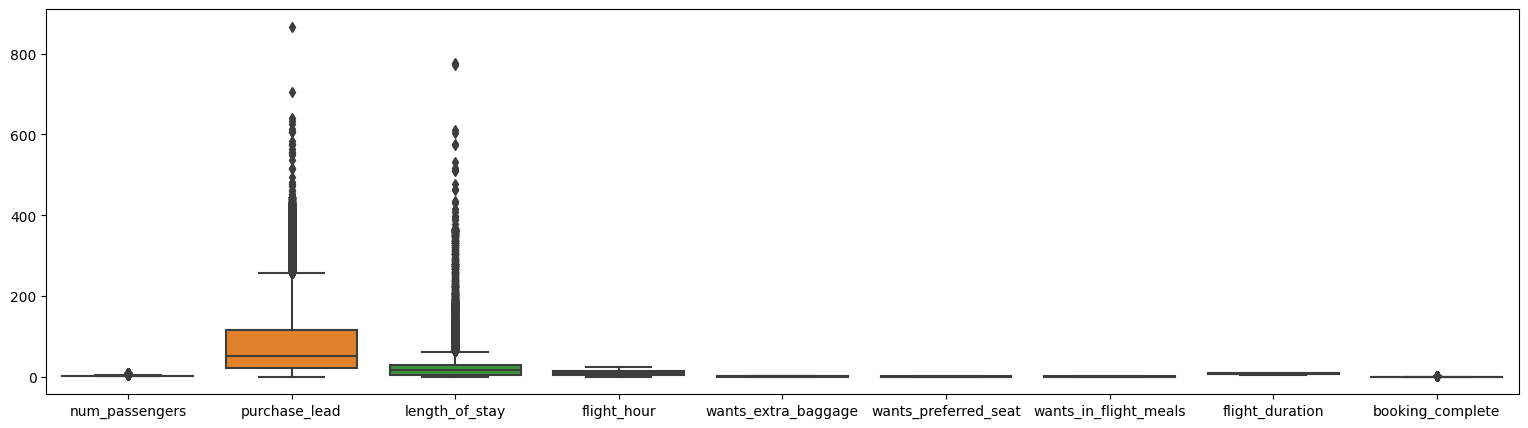

In [53]:
# Plotting boxplot for detecting outliers
plt.figure(figsize=(19,5))
sns.boxplot(data = data_numerical)
plt.show()

In [64]:
# Replacing outliers with median
#function to return a list of index of outliers
column_list = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour',
       'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals',
       'flight_duration']
for feature in column_list:
    Q1= data_numerical[feature].quantile(0.25)
    Q3 =data_numerical[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    median = data_numerical[feature].median()

    data_numerical[feature] = np.where(data_numerical[feature]< lower_limit, median,data_numerical[feature])
    data_numerical[feature] = np.where(data_numerical[feature]> upper_limit, median,data_numerical[feature])

Mutual Information classifier

In [65]:
# combining numerical and categorical column data
df = pd.concat([data_categorical,data_numerical], axis =1)

In [66]:
# Separating dependent and independent variables
X = df.drop(["booking_complete"] , axis=1)
y = df["booking_complete"]

In [67]:
#changing object dtype to int dtype
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

In [68]:
mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores

route                    0.053111
booking_origin           0.046963
flight_duration          0.020104
wants_extra_baggage      0.010424
length_of_stay           0.008674
num_passengers           0.005266
flight_day               0.005191
wants_preferred_seat     0.003149
flight_hour              0.002266
purchase_lead            0.001740
wants_in_flight_meals    0.001678
sales_channel            0.000203
trip_type                0.000000
Name: MI Scores, dtype: float64

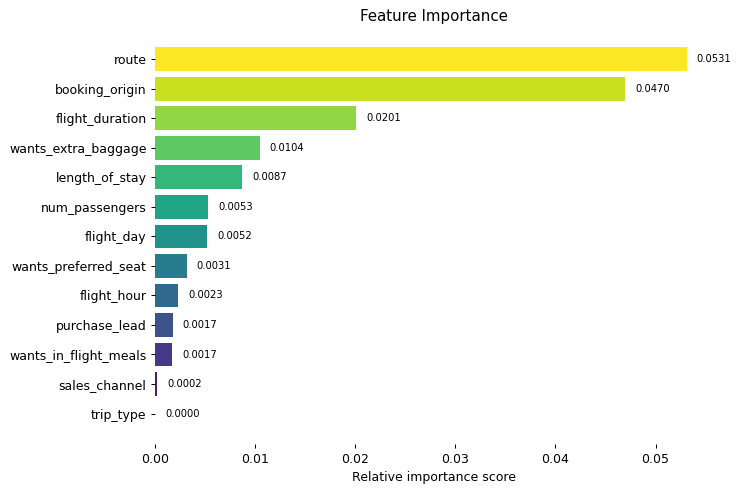

In [87]:
# Sort the scores in ascending order
mi_scores = mi_scores.sort_values(ascending=True)

# Define a color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(mi_scores)))

# Create the bar plot
plt.figure(dpi=90, figsize=(8, 6))
bars = plt.barh(mi_scores.index, mi_scores, color=colors, edgecolor='none')

# Add labels and title
plt.xlabel('Relative importance score')
plt.title('Feature Importance')

# Remove borders
plt.box(False)

# Add labels to the bars
for bar, score in zip(bars, mi_scores):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height() / 2, f'{score:.4f}', ha='left', va='center', fontsize=8)

plt.show()

Prepping data for modelling


In [21]:
#test train data split
def dataset(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
    return(X_train, X_test, y_train, y_test)

In [17]:
# Scaling the factors
def scale(X):
    scaler = MinMaxScaler()
    scaler.fit(X)
    return X

In [18]:
# using imblearn to removing imablance in our dataset
def smoteTeq(X,y):
    smote = SMOTE()
    X_smote, y_smote = smote.fit_resample(scale(X), y)
    # print(X_smote.shape)
    # print(y_smote.shape)
    return X_smote, y_smote

In [36]:
# function to print accuracy and roc - auc scores
def scores(y_test,y_pred):
    accuracy = accuracy_score(y_test,y_pred)*100
    auc_score = roc_auc_score(y_test,y_pred)
    return accuracy, auc_score

In [70]:
#assigning the features under a list
features=['route','booking_origin','flight_duration','wants_extra_baggage', 'length_of_stay', 'num_passengers', 'flight_day']
X= df[features]
#one hot encoding
X = pd.get_dummies(X, columns=features)
X= scale(X)
y= df.booking_complete
X, y = smoteTeq(X,y)
X_train,X_test,y_train,y_test= dataset(X,y)

Random forest Classfier with best 7 features

In [71]:
forest_model= RandomForestClassifier(n_estimators=56, random_state=1)
forest_model.fit(X_train, y_train)
# Make predictions on the test set
y_pred_rf= forest_model.predict(X_test)
print("Accuracy: {:.2f}%, \nAUC Score: {:.4f}".format(*scores(y_test, y_pred_rf)))

Accuracy: 90.33%, 
AUC Score: 0.9033


Balanced Random Forest Classifier with best 7 features

In [72]:
brf_classifier = BalancedRandomForestClassifier(n_estimators=56, random_state=42)
brf_classifier.fit(X_train, y_train)
# Make predictions on the test set
y_pred_brf = brf_classifier.predict(X_test)
print("Accuracy: {:.2f}%, \nAUC Score: {:.4f}".format(*scores(y_test, y_pred_brf)))

Accuracy: 90.27%, 
AUC Score: 0.9028


Easy Ensemble Classifier with best 7 features

In [ ]:
# Create and train an EasyEnsemble classifier
ee_classifier = EasyEnsembleClassifier(n_estimators=56, random_state=101)
ee_classifier.fit(X_train, y_train)
# Make predictions on the test set
y_pred_ee = ee_classifier.predict(X_test)
print("Accuracy: {:.2f}%, \nAUC Score: {:.4f}".format(*scores(y_test, y_pred_ee)))

In [73]:
X= df.drop('booking_complete', axis=1)
#one hot encoding
X = pd.get_dummies(X)
X= scale(X)
y= df.booking_complete
X, y = smoteTeq(X,y)
X_train,X_test,y_train,y_test= dataset(X,y)

Random forest Classifier with all features

In [74]:
forest_model= RandomForestClassifier(n_estimators=56, random_state=1)
forest_model.fit(X_train, y_train)
y_pred_rf= forest_model.predict(X_test)
print('ACCURACY:{:0.2f}% \nAUC score:{:0.4f}'.format(*scores(y_test,y_pred_rf)))

ACCURACY:90.93% 
AUC score:0.9094


In [98]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     10607
           1       0.95      0.86      0.91     10654

    accuracy                           0.91     21261
   macro avg       0.91      0.91      0.91     21261
weighted avg       0.91      0.91      0.91     21261



In [96]:
rf_imp_features = pd.DataFrame({'features':X_train.columns,'importance':np.round(forest_model.feature_importances_,3)})
rf_imp_features = rf_imp_features.sort_values('importance',ascending=False)
rf_imp_features

,features,importance
823,booking_origin_Australia,0.094
1,purchase_lead,0.067
2,length_of_stay,0.063
3,flight_hour,0.059
6,wants_in_flight_meals,0.059
...,...,...
90,route_BWNHGH,0.000
392,route_HKTKTM,0.000
89,route_BWNDEL,0.000
394,route_HKTMRU,0.000


Balanced Randomforest Classifier with all features

In [75]:
brf_classifier = BalancedRandomForestClassifier(n_estimators=56, random_state=42)
brf_classifier.fit(X_train, y_train)
# Make predictions on the test set
y_pred_brf = brf_classifier.predict(X_test)
print('ACCURACY:{:0.2f}% \nAUC score:{:0.4f}'.format(*scores(y_test,y_pred_brf)))

ACCURACY:90.93% 
AUC score:0.9094


Easy ensemble classifier with all features

In [ ]:
# Create and train an EasyEnsemble classifier
ee_classifier = EasyEnsembleClassifier(n_estimators=56, random_state=101)
ee_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_ee = ee_classifier.predict(X_test)
print('ACCURACY:{:0.2f}% \nAUC score:{:0.4f}'.format(*scores(y_test,y_pred_ee)))